In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [3]:
# load data
data_path = "../data/depression.csv"
data = pd.read_csv(data_path)

In [4]:
data = data.dropna(axis=1)

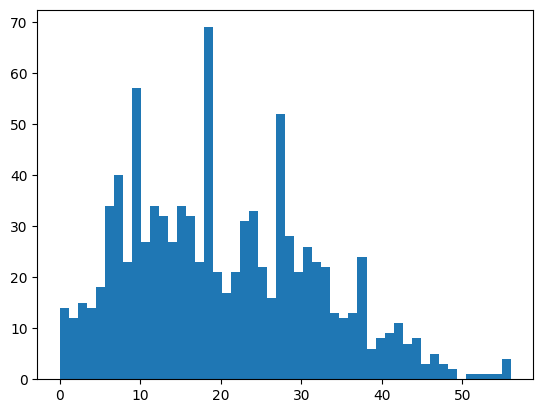

In [5]:
plt.hist(data["cesd_total"], bins=50)
plt.show()

/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


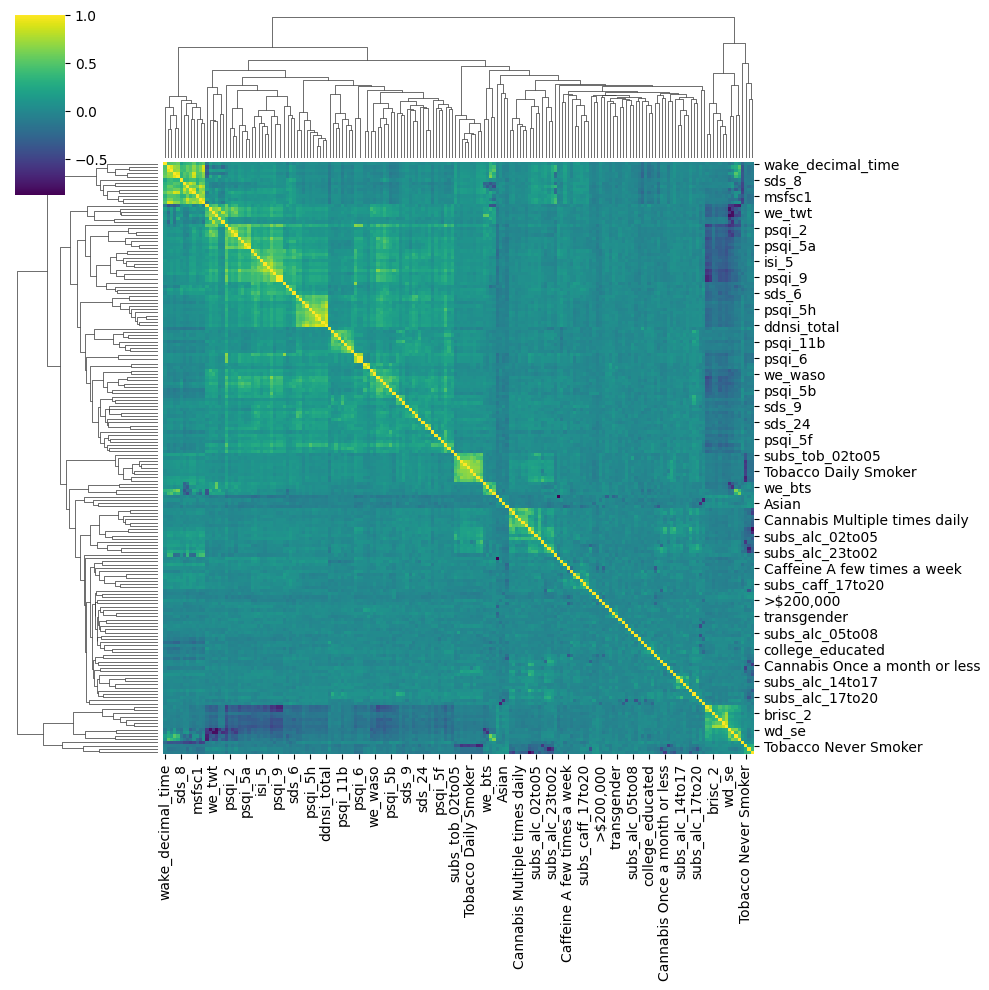

In [4]:
sns.clustermap(data.corr(), cmap='viridis')
plt.show()

In [6]:
X = data.iloc[:,:182].values
y = data.iloc[:,182].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [8]:
# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [9]:
def identify_variable_types(data):
    continuous_vars = []
    dummy_vars = []

    num_columns = data.shape[1]
    
    for i in range(num_columns):
        unique_values = np.unique(data[:, i])
        if len(unique_values) == 2 and np.array_equal(unique_values, [0, 1]):
            dummy_vars.append(i)
        else:
            continuous_vars.append(i)
    
    return continuous_vars, dummy_vars

In [10]:
continuous_cols_train, dummy_cols_train = identify_variable_types(X_train)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols_train),
        ('dummy', 'passthrough', dummy_cols_train)  # Leave dummy variables unchanged or use StandardScaler() if needed
    ]
)

# Fit and transform the data
X_train = preprocessor.fit_transform(X_train)

In [11]:
continuous_cols_val, dummy_cols_val = identify_variable_types(X_val)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols_val),
        ('dummy', 'passthrough', dummy_cols_val)  # Leave dummy variables unchanged or use StandardScaler() if needed
    ]
)

# Fit and transform the data
X_val = preprocessor.fit_transform(X_val)

In [12]:
continuous_cols_test, dummy_cols_test = identify_variable_types(X_test)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols_test),
        ('dummy', 'passthrough', dummy_cols_test)  # Leave dummy variables unchanged or use StandardScaler() if needed
    ]
)

# Fit and transform the data
X_test = preprocessor.fit_transform(X_test)

In [13]:
model_performances = []

In [14]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    model_performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [15]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    evaluate(model=None, 
             X=x, y=y, 
             nsplit=nsplit, 
             model_name='dummy', 
             constant_value=y_train.mean())

In [16]:
reg = LinearRegression().fit(X_train, y_train)
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    evaluate(model=reg, 
                X=x, y=y, 
                nsplit=nsplit, 
                model_name=f'linear')

In [17]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        for x,y,nsplit in zip([X_train, X_val, X_test],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear-{id}-alpha-{alpha}')

In [63]:
perf_df_filtered = perf_df[perf_df['model'] != 'linear']

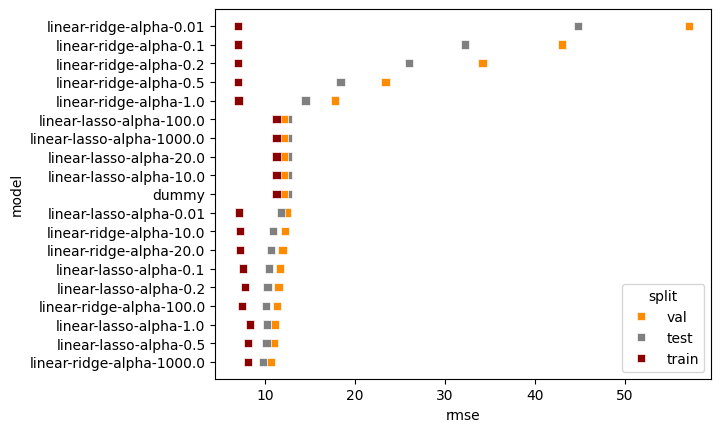

In [65]:
#perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df_filtered.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

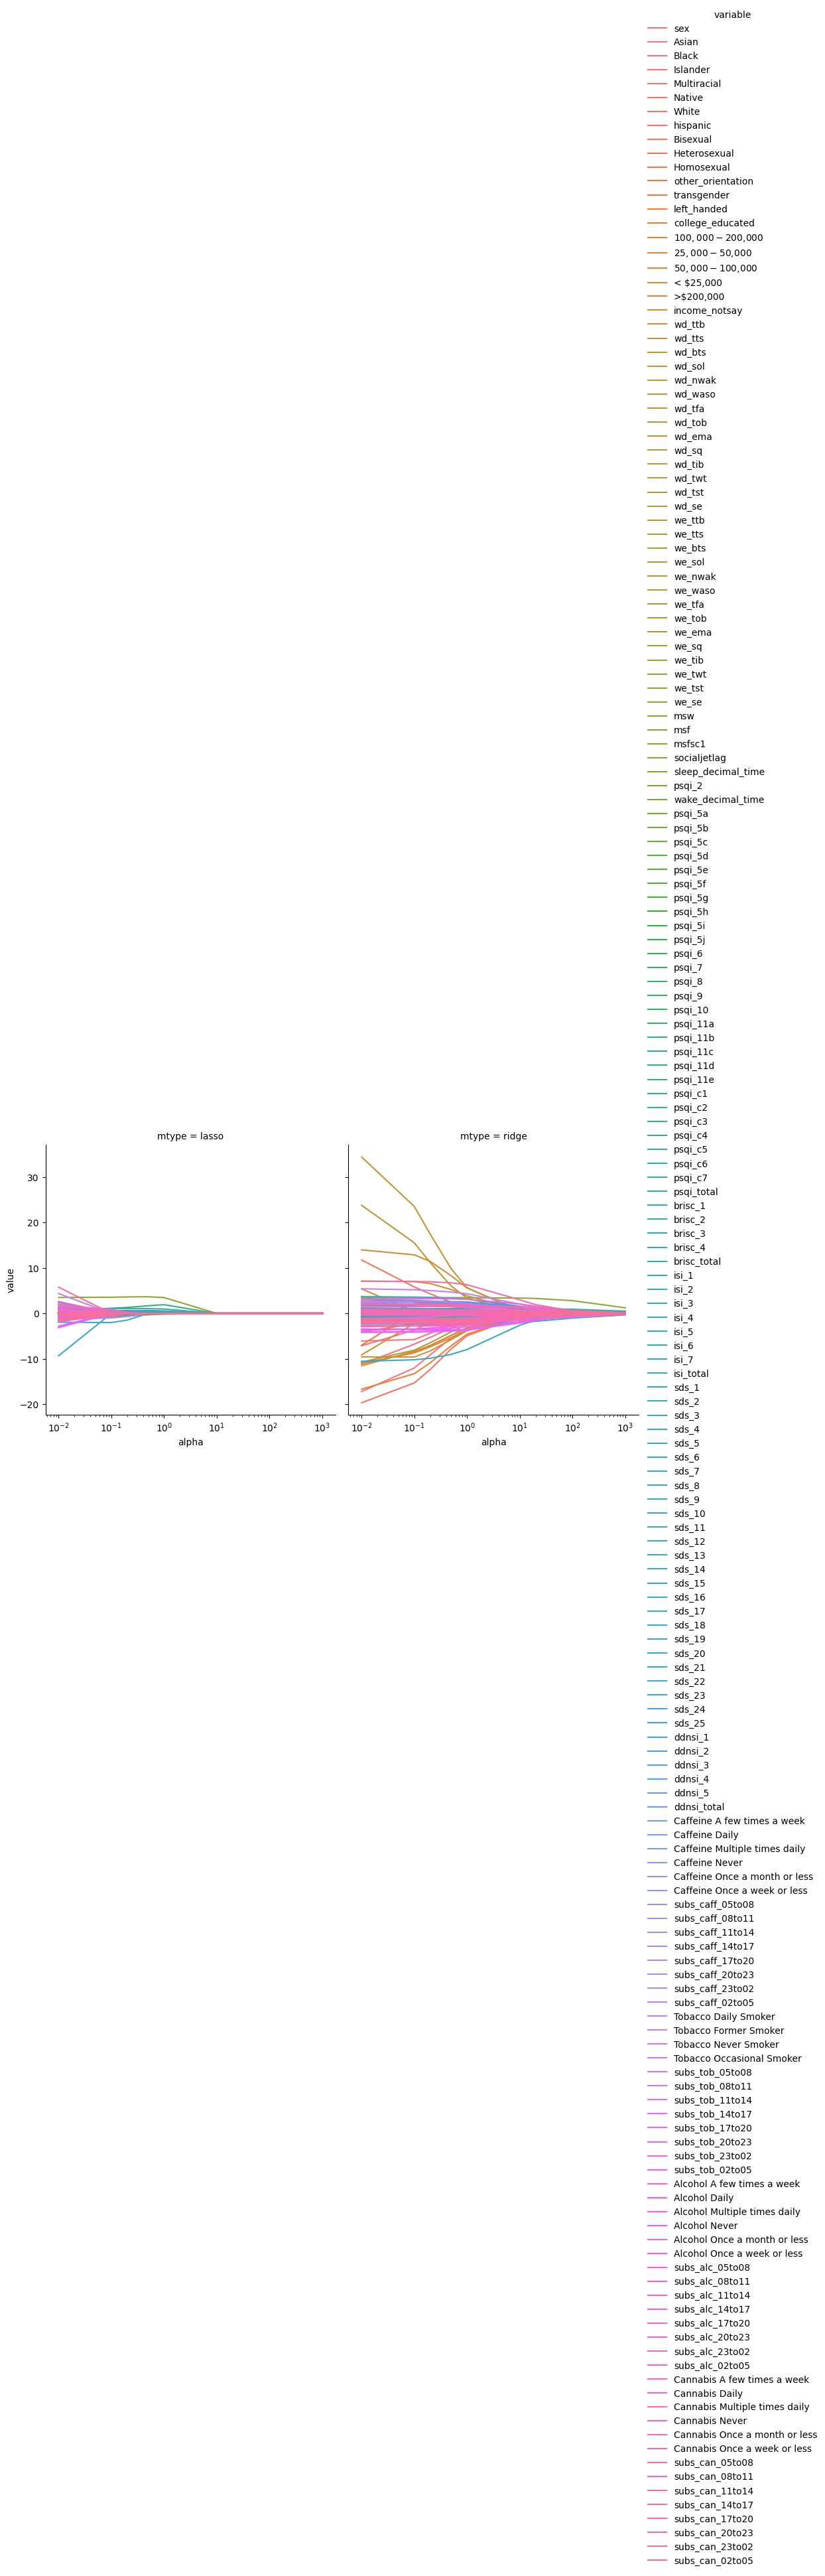

In [18]:
coefs = pd.DataFrame(np.vstack([v.coef_.round(4) for v in models.values()]),
                     columns=data.iloc[:,:182].columns)
coefs['mtype'] = [k.split('-')[0] for k in models.keys()]
coefs['alpha'] = [float(k.split('-')[1]) for k in models.keys()]
coefs = pd.melt(coefs, id_vars=['mtype', 'alpha'])# turning data into long format 

grid = sns.relplot(data=coefs[coefs['mtype']!='linear'], 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")

In [18]:
def _compute_bias(pred, true):
    ''' Function to compute bias. 
        Note that here we compute the average squared bias of the model
        over all data points to get a sense for its tendency to make 
        systematically "off-target" predictions.

    Args:
        pred (np.array): array of shape (n_samples, n_bootstrap), where n_samples is the size
            of the test set, and n_bootstraps is how many times we sample data from the training
            set and fit our model
        true (np.array): predictions of the true model. It is an array of shape (n_samples)
    '''
    mpred = pred.mean(axis=1)
    return (((true - mpred)**2)).mean()

In [19]:
def _compute_variance(pred):
    ''' Function to compute variance
    Args:
        pred (np.array): array of shape (n_samples, n_bootstrap), where n_samples is the size
            of the test set, and n_bootstraps is how many times we sample data from the training
            set and fit our model
    '''
    return pred.var(axis=1).mean()

In [20]:
max_degree = 10 # this defines the most complex model we will fit (with x, ..., x^10) as inputs
n_sim = 1000 # this defines how many times we do bootstrapping
performances = [] # here we will store performances
results = [] # here we store performances as a DF (see logic in the loop)
outputs = ['mtype', # this is the information we want to store in the DF
           'complexity', 
           'bias^2', 
           'variance', 
           'mse']

for c in range(1, max_degree):
    reg = LinearRegression() # initialize the model 
    pred_all = np.zeros(shape=(y_test.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps
    for sim in range(n_sim): # bootstrap n_sim times
        x, _, y, _ = train_test_split(X_train, y_train, train_size=.5) # sample half of the data
        transformer = PolynomialFeatures(degree=c)
        x_fit = transformer.fit_transform(x[:,1].reshape(-1,1)) # take x, and add all polynomials all the way to c (current complexity)
        x_test = transformer.fit_transform(X_test[:,1].reshape(-1,1)) # do the same with the test set
        reg.fit(x_fit,y) # fit the model
        preds = reg.predict(x_test) # predict the outcomes
        pred_all[:,sim] = preds # store that in the big result matrix

    # once we are done bootstrapping, we have predictions for all models
    mse = np.mean([np.sqrt(mean_squared_error(y_test, 
                                              pred_all[:,sim])) # compute the average MSE of the models
                    for sim in range(n_sim)])
    bias = _compute_bias(pred_all, y_test) # get bias
    variance = _compute_variance(pred_all) # get variance
    info = ('linear', x_fit.shape[1]-1, bias, variance, mse)
    performances.append(info) # append model info to performances

# Getting the results into a dataframe 
result = pd.DataFrame(performances, columns=outputs)
for c in ['bias^2', 'variance', 'mse']:
    result[f'{c}-scaled'] = MinMaxScaler().fit_transform(result[c].values.reshape(-1,1)) # rescale, so bias and variance are on the same scale
results.append(result)

In [21]:
df = pd.concat(results)

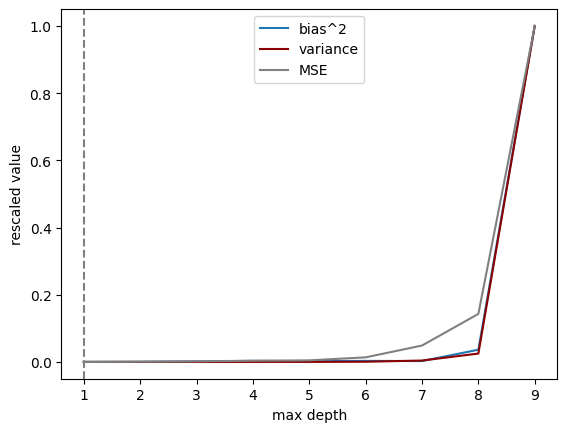

In [22]:
sns.lineplot(data=df, x='complexity', y='bias^2-scaled', label='bias^2')
sns.lineplot(data=df, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=df, x='complexity', y='mse-scaled', label='MSE', color='grey')
plt.xlabel('max depth')
plt.ylabel('rescaled value')
plt.axvline(x=df.iloc[df['mse'].argmin()]['complexity'], 
            linestyle='--',
            color='grey')
plt.show()

In [23]:
max_depth = 20 # this defines the most complex model we will fit (with x, ..., x^10) as inputs
n_sim = 1000 # this defines how many times we do bootstrapping
performances = [] # here we will store performances
results = [] # here we store performances as a DF (see logic in the loop)
outputs = ['mtype', # this is the information we want to store in the DF
           'complexity', 
           'bias^2', 
           'variance', 
           'mse']

for c in range(1, max_depth):
    reg = DecisionTreeRegressor(max_depth=c) # initialize the model 
    pred_all = np.zeros(shape=(y_test.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps
    for sim in range(n_sim): # bootstrap n_sim times
        x, _, y, _ = train_test_split(X_train, y_train, train_size=.5) # sample half of the data
        reg.fit(x,y) # fit the model
        preds = reg.predict(X_test) # predict the outcomes
        pred_all[:,sim] = preds # store that in the big result matrix

    # once we are done bootstrapping, we have predictions for all models
    mse = np.mean([np.sqrt(mean_squared_error(y_test, 
                                              pred_all[:,sim])) # compute the average MSE of the models
                    for sim in range(n_sim)])
    bias = _compute_bias(pred_all, y_test) # get bias
    variance = _compute_variance(pred_all) # get variance
    info = ('tree', c, bias, variance, mse)
    performances.append(info) # append model info to performances

# Getting the results into a dataframe 
result = pd.DataFrame(performances, columns=outputs)
for c in ['bias^2', 'variance', 'mse']:
    result[f'{c}-scaled'] = MinMaxScaler().fit_transform(result[c].values.reshape(-1,1)) # rescale, so bias and variance are on the same scale
results.append(result)

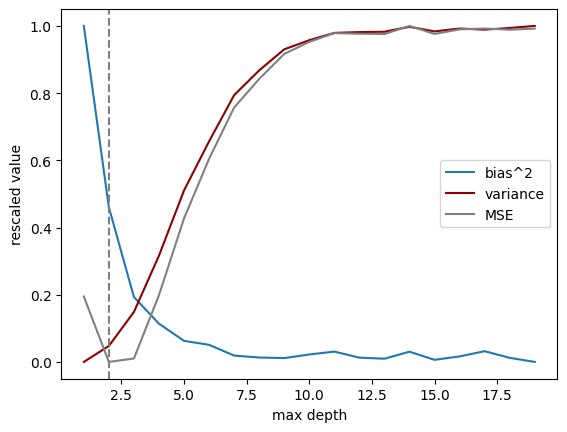

In [24]:
df = pd.concat(results)
sns.lineplot(data=df, x='complexity', y='bias^2-scaled', label='bias^2')
sns.lineplot(data=df, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=df, x='complexity', y='mse-scaled', label='MSE', color='grey')
plt.xlabel('max depth')
plt.ylabel('rescaled value')
plt.axvline(x=df.iloc[df['mse'].argmin()]['complexity'], 
            linestyle='--',
            color='grey')
plt.show()

In [25]:
parameters = {'max_depth': range(1,10), 
              'min_samples_split': np.arange(1,100,10),
              'ccp_alpha': [0.01, 0.1, 1.0, 10.0]}

clf = GridSearchCV(DecisionTreeRegressor(), 
                   parameters, 
                   n_jobs=1, 
                   scoring='neg_mean_squared_error', 
                   cv=5)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print(clf.best_params_) 

predicted = tree_model.predict(X_test)
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, 
                                                predicted)))

{'ccp_alpha': 0.01, 'max_depth': 5, 'min_samples_split': 91}
test RMSE:  11.630235534960878


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ucloud/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ucloud/.local/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/ucloud/.local/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/ucloud/.l

In [26]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [27]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    model_performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [28]:
rfreg = RandomForestRegressor(random_state=42) # first, we instantiate the estimator

In [29]:
param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
    'ccp_alpha': [0.01, 0.1, 1.0]
}

In [30]:
cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=20, # this should more likely be above 100, and in general the higher the better
                            cv=5)
cv_rfr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'ccp_alpha': [0.01, 0.1, 1.0],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': [0.3, 0.6, 0.9],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 100, 200,
                                                         500]},
                   scoring='neg_mean_squared_error')

In [31]:
cv_rfr.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.1,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 0.3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [32]:
evaluate(model=cv_rfr.best_estimator_, model_name=f'random-forest')

In [33]:
from sklearn.inspection import permutation_importance
#importances = permutation_importance(cv_rfr.best_estimator_, X_train, y_train,
#                                     n_repeats=30,
#                                     random_state=0,
#                                     scoring='neg_mean_squared_error')['importances_mean']
importances = cv_rfr.best_estimator_.feature_importances_
# the above computes the (normalized) total reduction of the criterion brought by that feature.

In [34]:
feature_names = data.columns.tolist()[:-1]

In [35]:
len(feature_names) == X_train.shape[1]

True

In [73]:
len(feature_names)

182

In [71]:
importances.shape

(181,)

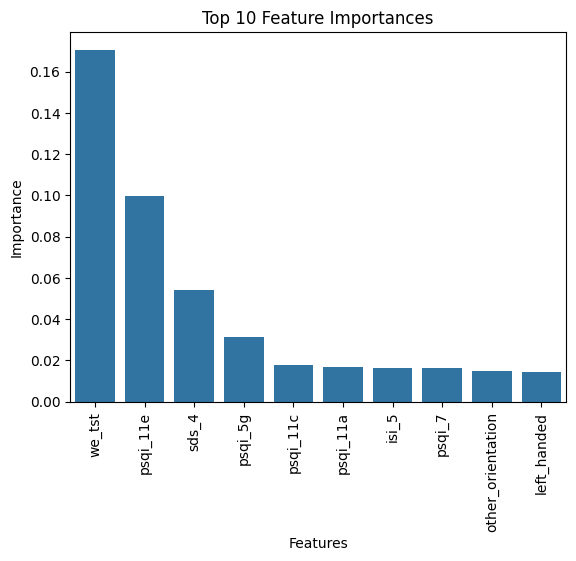

In [36]:
# Get the indices of the top 10 features based on their importances
top_10_indices = np.argsort(importances)[-10:][::-1]

# Select the top 10 feature names and their importances
top_10_feature_names = [feature_names[i] for i in top_10_indices]
top_10_importances = importances[top_10_indices]

# Plot the top 10 feature importances using seaborn barplot
sns.barplot(x=top_10_feature_names, y=top_10_importances, color=sns.color_palette()[0])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [37]:
xgbreg = XGBRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'objective': ['reg:squarederror'],
    'colsample_bytree': [0.3, 0.6, 0.9],
    'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
}

In [38]:
cv_xgb = RandomizedSearchCV(estimator=xgbreg, 
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error',
                            n_iter=20, # this should be at least 100
                            cv=5)
cv_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.3, 0.6, 0.9],
                                        'learning_rate': [2e-05, 0.0002, 0.002,
                                                          0.02, 0.2],
                                        'max_depth': [2, 3, 5, 10],
                                        'n_estimators': [10, 20, 100, 200, 500],
                                        'objective': ['reg:squarederror']},
                   scoring='neg_mean_squared_error')

In [39]:
cv_xgb.best_estimator_.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [40]:
evaluate(model=cv_xgb.best_estimator_, model_name=f'xgboost')

In [41]:
importances = cv_xgb.best_estimator_.feature_importances_

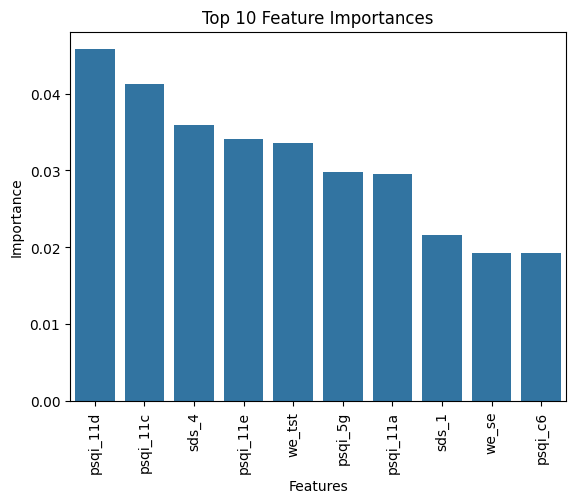

In [42]:
# Get the indices of the top 10 features based on their importances
top_10_indices = np.argsort(importances)[-10:][::-1]

# Select the top 10 feature names and their importances
top_10_feature_names = [feature_names[i] for i in top_10_indices]
top_10_importances = importances[top_10_indices]

# Plot the top 10 feature importances using seaborn barplot
sns.barplot(x=top_10_feature_names, y=top_10_importances, color=sns.color_palette()[0])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [46]:
model_performances

[{'model': 'dummy', 'split': 'train', 'rmse': 11.2661, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 12.044, 'r2': -0.0241},
 {'model': 'dummy', 'split': 'test', 'rmse': 12.5069, 'r2': -0.0051},
 {'model': 'linear', 'split': 'train', 'rmse': 6.9475, 'r2': 0.6197},
 {'model': 'linear',
  'split': 'val',
  'rmse': 55978618892232.44,
  'r2': -2.2122366196762484e+25},
 {'model': 'linear',
  'split': 'test',
  'rmse': 45297602434711.734,
  'r2': -1.3183983522923074e+25},
 {'model': 'linear-lasso-alpha-0.01',
  'split': 'train',
  'rmse': 7.1045,
  'r2': 0.6023},
 {'model': 'linear-lasso-alpha-0.01',
  'split': 'val',
  'rmse': 12.3959,
  'r2': -0.0848},
 {'model': 'linear-lasso-alpha-0.01',
  'split': 'test',
  'rmse': 11.7864,
  'r2': 0.1074},
 {'model': 'linear-ridge-alpha-0.01',
  'split': 'train',
  'rmse': 6.9584,
  'r2': 0.6185},
 {'model': 'linear-ridge-alpha-0.01',
  'split': 'val',
  'rmse': 57.0004,
  'r2': -21.9374},
 {'model': 'linear-ridge-alpha-0.01',
  'split': 'tes

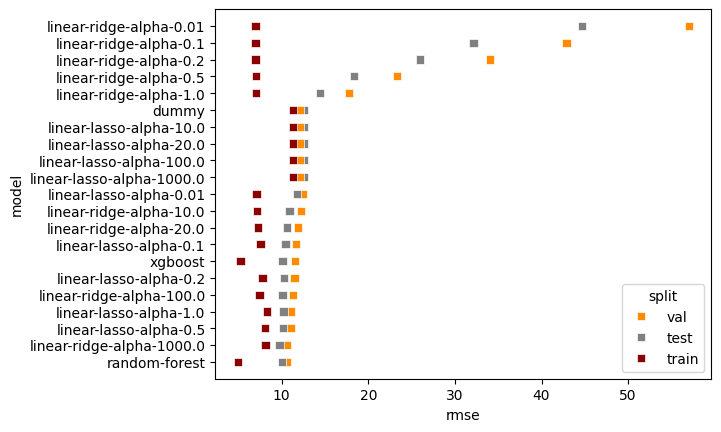

In [47]:
perf_df = pd.DataFrame(model_performances)
perf_df_filtered = perf_df[perf_df['model'] != 'linear']
sns.scatterplot(data=perf_df_filtered.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()